# Segmentation of Indian Traffic

In [1]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib

In [2]:
!gdown --id 1iQ93IWVdR6dZ6W7RahbLq166u-6ADelJ

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2231M  100 2231M    0     0   143M      0  0:00:15  0:00:15 --:--:--  160M


In [3]:
!unzip -q data.zip

# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [4]:
def return_file_names_df(root_dir):
    # write the code that will create a dataframe with two columns ['images', 'json']
    # the column 'image' will have path to images
    # the column 'json' will have path to json files
    columns = ['image','json']
    data_df = pd.DataFrame()
    k=0
    for i in sorted(os.listdir(root_dir)):
        for root, dirs, files in os.walk(root_dir+'/'+i):
            dirs.sort()
            arr = []
            for dir in dirs:
                files = os.listdir(path.join(root,dir))
                files.sort()
                for name in files:
                    arr.append(path.join(root,dir,name))
            break
        data_df[columns[k]] = arr
        k+=1
    
    return data_df

In [5]:
os.listdir('data')

['images', 'mask']

In [6]:
data_df = return_file_names_df('data')
data_df.head()

,image,json
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json


> If observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

## 2. Structure of sample Json file

<img src='https://i.imgur.com/EfR5KmI.png'>

* Each File has 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object has multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### Compute the unique labels

Let's see how many unique objects are there in the json file.

In [1]:
def return_unique_labels(data_df):

    arr = []
    # for each file in the column json
    for i in data_df['json'].values:
    #       read and store all the objects present in that file
        f = open(i)
        data = json.load(f)
        f.close()
        for j in data['objects']:
            arr.append(j['label'])
    # compute the unique objects and retrun them
    unique_labels = set(arr)
    return unique_labels

In [12]:
unique_labels = return_unique_labels(data_df)

<img src='https://i.imgur.com/L4QH6Tp.png'>

In [13]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

## 3. Extracting the polygons from the json files

In [16]:
def get_poly(file):
    # this function will take a file name as argument
    
    # it will process all the objects in that file and returns
    
    # label: a list of labels for all the objects label[i] will have the corresponding vertices in vertexlist[i]
    # len(label) == number of objects in the image
    
    label, vertexlist = [], []
    f = open(file)
    data = json.load(f)
    f.close()
    for i in data['objects']:
        arr = []
        label.append(i['label'])
        for j in i['polygon']:
            arr.append(tuple(j))
        vertexlist.append(arr)

    h = data['imgHeight']
    w = data['imgWidth']

    return w, h, label, vertexlist

## 4. Creating Image segmentations by drawing set of polygons

### Example

(28, 28, 3)
[[0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0]
 [0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0]
 [0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0]
 [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0]
 [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0]
 [0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0]
 [0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 

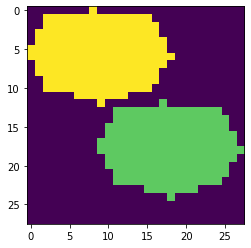

In [20]:
import math 
from PIL import Image, ImageDraw 
from PIL import ImagePath  
side=8
x1 = [ ((math.cos(th) + 1) *9, (math.sin(th) + 1) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
x2 = [ ((math.cos(th) + 2) *9, (math.sin(th) + 3) *6) for th in [i * (2 * math.pi) / side for i in range(side)] ]

img = Image.new("RGB", (28,28))
img1 = ImageDraw.Draw(img)
# please play with the fill value
# writing the first polygon
img1.polygon(x1, fill =40)
# writing the second polygon
img1.polygon(x2, fill =30)

img=np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
plt.imshow(img[:,:,0])
print(img.shape)
print(img[:,:,0]//10)
im = Image.fromarray(img[:,:,0])
im.save("test_image.png")

In [23]:
def compute_masks(data_df):
    # after we have computed the vertexlist plot that polygone in image like this
    mask_paths = []
    for file in tqdm(data_df['json'].values):
        w, h, labels, vertexlist = get_poly(file)
        img = Image.new("RGB", (w, h))
        img1 = ImageDraw.Draw(img)
        for i in range(len(vertexlist)):
            if(len(vertexlist[i]) > 1):
                img1.polygon(vertexlist[i], fill = label_clr[labels[i]])
        
        # after drawing all the polygons that we collected from json file, 
        # we need to store that image in the folder like this "data/output/scene/framenumber_gtFine_polygons.png"
        img=np.array(img)
        im = Image.fromarray(img[:,:,0])
        if not os.path.isdir('data/output'):
            os.makedirs('data/output')
        if not os.path.isdir('data/output/'+file.split('/')[2]):
            os.makedirs('data/output/'+file.split('/')[2])
        location = path.join('data/output',file.split('/')[2],file.split('/')[3].split('.')[0]+'.png')
        im.save(location)

        # after saving the image into disk, store the path in a list
        # after storing all the paths, add a column to the data_df['mask'] ex: data_df['mask']= mask_paths
        mask_paths.append(location)
    data_df['mask']= mask_paths
    
    return data_df

In [24]:
data_df = compute_masks(data_df)
data_df.head()

100%|██████████| 4008/4008 [04:34<00:00, 14.60it/s]


,image,json,mask
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json,data/output/201/frame0029_gtFine_polygons.png
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json,data/output/201/frame0299_gtFine_polygons.png
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json,data/output/201/frame0779_gtFine_polygons.png
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json,data/output/201/frame1019_gtFine_polygons.png
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json,data/output/201/frame1469_gtFine_polygons.png


In [25]:
#daving the final dataframe to a csv file
data_df.to_csv('preprocessed_data.csv', index=False)

In [ ]:
data_df = pd.read_csv('preprocessed_data.csv')

In [ ]:
data_df.head()

,image,json,mask
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json,data/output/201/frame0029_gtFine_polygons.png
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json,data/output/201/frame0299_gtFine_polygons.png
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json,data/output/201/frame0779_gtFine_polygons.png
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json,data/output/201/frame1019_gtFine_polygons.png
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json,data/output/201/frame1469_gtFine_polygons.png


### Task 2.1: Dice loss


* Dice loss
* 1. Formualtion

   ${D} = \frac{ 2 \sum \limits _{i=1} ^{N} {p}_{i} {g}_{i}} {\sum \limits _{i=1} ^{N} {p}_{i}^{2} + \sum \limits _{i=1} ^{N} {g}_{i}^{2}} $ 
 
* 2. Range of the loss function

range is between 0 and 1.
* 3. Interpretation of loss function

Here, pi and gi are prediction and corresponding ground truth pixel values respectively.
* 4. understanding of the loss function

 The overlap between ground truth and predicted pixel masks is given the most importance. If there is perfect overlap then Dice loss will be maximum (i.e. 1) and if there is no overlap loss will be minimum (i.e. 0). 
This loss is calculated for each class mask separately and the total loss is calculated by averaging over all class mask losses.
Since Dice loss is a loss maximizing problem, we can calculate (1-Dice loss) to pose it as a loss minimizing problem.

Split the dataset

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(data_df, test_size=0.1, random_state=42)

In [28]:
import tensorflow as tf
import segmentation_models as sm
from segmentation_models import Unet
sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

Segmentation Models: using `keras` framework.


In [29]:
import imgaug.augmenters as iaa
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [30]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()
    
def normalize_image(mask):
    mask = mask/255
    return mask

class Dataset:
    # we will be modifying this CLASSES according to our data/problems
    CLASSES = ['edited','non-edited']
    
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, file_names, classes,type):
        
        self.w = 256
        self.h = 256
        # the paths of images
        self.images_fps   = file_names['image'].values
        # the paths of segmentation images
        self.masks_fps    = file_names['mask'].values
        # giving labels for each class
        self.class_values = classes
        self.type = type
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED) 
        image = cv2.resize(image,(self.w,self.h),interpolation=cv2.INTER_NEAREST)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = normalize_image(image)

        mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED) 
        mask = cv2.resize(mask,(self.w,self.h),interpolation=cv2.INTER_NEAREST)

        
        image_masks = [(mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
   
        if self.type == 'train':
            a = np.random.uniform()
            if a<0.2:
                image = aug2.augment_image(image)
                image_mask = aug2.augment_image(image_mask)
            elif a<0.4:
                image = aug3.augment_image(image)
                image_mask = aug3.augment_image(image_mask)
            elif a<0.6:
                image = aug4.augment_image(image)
                image_mask = aug4.augment_image(image_mask)
            elif a<0.8:
                image = aug5.augment_image(image)
                image_mask = image_mask
            else:
                image = aug6.augment_image(image)
                image_mask = aug6.augment_image(image_mask)
            
        return image, image_mask
        
    def __len__(self):
        return len(self.images_fps)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

# Task 3: Training CANet

In [31]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


* We can devide the whole architecture can be devided into two parts
    1. Encoder
    2. Decoder
    <img src='https://i.imgur.com/prH3Mno.png' width="600">
* Encoder:
    * The first step of the encoder is to create the channel maps [$C_1$, $C_2$, $C_3$, $C_4$]
    * $C_1$ width and heigths are 4x times less than the original image
    * $C_2$ width and heigths are 8x times less than the original image
    * $C_3$ width and heigths are 8x times less than the original image
    * $C_4$ width and heigths are 8x times less than the original image
    * <i>we can reduce the dimensions by using stride parameter</i>.
    * [$C_1$, $C_2$, $C_3$, $C_4$] are formed by applying a "conv block" followed by $k$ number of "identity block". i.e the $C_k$ feature map will single "conv block" followed by $k$ number of "identity blocks".
    <table>
    <tr><td><img src="https://i.imgur.com/R8Gdypo.png" width="300"></td>
        <td><img src="https://i.imgur.com/KNunjQK.png" width="250"></td></tr>
    </table>
    * <strong>The conv block and identity block of $C_1$</strong>: the number filters in the covolutional layers will be $[4,4,8]$ and the number of filters in the parallel conv layer will also be $8$.
    * <strong>The conv block and identity block of $C_2$</strong>: the number filters in the covolutional layers will be $[8,8,16]$ and the number of filters in the parallel conv layer will also be $16$.
    * <strong>The conv block and identity block of $C_3$</strong>: the number filters in the covolutional layers will be $[16,16,32]$ and the number of filters in the parallel conv layer will also be $32$.
    * <strong>The conv block and identity block of $C_4$</strong>: the number filters in the covolutional layers will be $[32,32,64]$ and the number of filters in the parallel conv layer will also be $64$.
    * Here $\oplus$ represents the elementwise sum
    <br>

In [32]:
class convolutional_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3, filters=[4,4,8],stride=1, name="conv_block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride = stride
        self.conv_1 = Conv2D(self.F1, 1, 1,padding ='same',activation='relu',kernel_initializer = glorot_uniform(seed=0))
        self.bn1 = BatchNormalization(axis=3)
        self.bn2 = BatchNormalization(axis=3)
        self.bn3 = BatchNormalization(axis=3)
        self.bn4 = BatchNormalization(axis=3)
        self.add = Add()
        self.conv_2 = Conv2D(self.F2, self.kernel, self.stride, padding ='same', activation='relu',kernel_initializer = glorot_uniform(seed=0))
        self.conv_parallel = Conv2D(self.F3, self.kernel,self.stride,padding ='same', activation='relu',kernel_initializer = glorot_uniform(seed=0))
        self.conv_3 = Conv2D(self.F3, 1,padding ='same', activation='relu',kernel_initializer = glorot_uniform(seed=0))
        self.act = Activation('relu')
    def call(self, X):
        # write the architecutre that was mentioned above
        X_parallel = X
        X_parallel = self.conv_parallel(X_parallel)
        X_parallel = self.bn1(X_parallel)
        X_parallel = self.act(X_parallel)

        X = self.conv_1(X)
        X = self.bn2(X)
        X = self.act(X)
        X = self.conv_2(X)
        X = self.bn3(X)
        X = self.act(X)
        X = self.conv_3(X)
        X = self.bn4(X)
        X = self.add([X,X_parallel])
        X = self.act(X)
        return X

In [33]:
class identity_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], name="identity_block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.conv_1 = Conv2D(self.F1, 1,padding ='same',activation='relu',kernel_initializer = glorot_uniform(seed=0))
        self.bn1 = BatchNormalization(axis=3)
        self.bn2 = BatchNormalization(axis=3)
        self.bn3 = BatchNormalization(axis=3)
        self.add = Add()
        self.conv_2 = Conv2D(self.F2, self.kernel,padding ='same', activation='relu',kernel_initializer = glorot_uniform(seed=0))
        self.conv_3 = Conv2D(self.F3, 1,padding ='same', activation='relu',kernel_initializer = glorot_uniform(seed=0))
        self.act = Activation('relu')
    def call(self, X):
        # write the architecutre that was mentioned above
        X_parallel = X
        X = self.conv_1(X)
        X = self.bn1(X)
        X = self.act(X)
        X = self.conv_2(X)
        X = self.bn2(X)
        X = self.act(X)
        X = self.conv_3(X)
        X = self.bn3(X)
        X = self.add([X,X_parallel])
        X = self.act(X)
        return X

* The output of the $C_4$ will be passed to $\text{Chained Context Aggregation Module (CAM)}$
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
* The CAM module will have two operations names Context flow and Global flow
* <strong>The Global flow</strong>: 
    * as shown in the above figure first we willl apply  <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D">global avg pooling</a> which results in (#, 1, 1, number_of_filters) then applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization?version=nightly">BN</a>, <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU">RELU</a>, $1*1 \text{ Conv}$ layer sequentially which results a matrix (#, 1, 1, number_of_filters). Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * We use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique
* <strong>The Context flow</strong>: 
    * as shown in the above figure (c) the context flow will get inputs from two modules `a. C4` `b. From the above flow` 
    * We will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate">concatinating</a> the both inputs on the last axis.
    * After the concatination we will be applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D"> Average pooling </a> which reduces the size of feature map by $N\times$ times
    * In the paper it was mentioned that to apply a group convolutions, but for the project we will be applying the simple conv layers with kernel size $(3*3)$
    * We are skipping the channel shuffling 
    * similarly we will be applying a simple conv layers with kernel size $(3*3)$ consider this output is X
    * later we will get the Y=(X $\otimes \sigma((1\times1)conv(relu((1\times1)conv(X))))) \oplus X$, here $\oplus$ is elementwise addition and $\otimes$ is elementwise multiplication
    * Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * We use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

NOTE: here N times reduction and N time increments makes the input and out shape same, we can explore with the N values, we can choose N = 2 or 4

* Example with N=2:
    * Assume the C4 is of shape (64,64,64) then the shape of GF will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of GF is (64,64,32) then the shape of CF1 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF1 is (64,64,32) then the shape of CF2 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF2 is (64,64,32) then the shape of CF3 will be (64,64,32)

In [34]:
class global_flow(tf.keras.layers.Layer):
    def __init__(self, input_shape, name="global_flow"):
        super().__init__(name=name)
        self.shape = input_shape[1]
        self.input_channels = input_shape[3]
        self.gap = GlobalAveragePooling2D(keepdims=True)
        self.bn = BatchNormalization(axis=3)
        self.act = Activation('relu')
        self.conv_1 = Conv2D(self.input_channels/2, 1,padding ='same',activation='relu')
        self.upsample = UpSampling2D(self.shape,interpolation='bilinear')
    def call(self, X):
        # implement the global flow operatiom
        X = self.gap(X)
        X = self.bn(X)
        X = self.act(X)
        X = self.conv_1(X)
        X = self.upsample(X)
        return X

In [35]:
class context_flow(tf.keras.layers.Layer):    
    def __init__(self, N = 2,name="context_flow"):
        super().__init__(name=name)
        self.concat = Concatenate(axis = 3)
        self.avgpool = AveragePooling2D(pool_size=(N, N),strides=(N, N))
        self.act1 = Activation('relu')
        self.act2 = Activation('sigmoid')
        self.multiply = Multiply()
        self.add = Add()
        self.conv1 = Conv2D(32, 3,padding ='same', activation='relu')
        self.conv2 = Conv2D(32, 3,padding ='same', activation='relu')
        self.conv3 = Conv2D(32, 1,padding ='same', activation='relu')
        self.conv4 = Conv2D(32, 1,padding ='same', activation='relu')
        self.upsample = UpSampling2D(N,interpolation='bilinear')
    def call(self, X):
        # here X will a list of two elements 
        INP, FLOW = X[0], X[1] 
        # implement the context flow as mentioned in the above cell
        X = self.concat([INP,FLOW])
        X = self.avgpool(X)
        X = self.conv1(X)
        X = self.conv2(X)
        X_1 = X

        X_parallel = self.conv3(X)
        X_parallel = self.act1(X_parallel)
        X_parallel = self.conv4(X_parallel)
        X_parallel = self.act2(X_parallel)

        X = self.multiply([X_1,X_parallel])
        X = self.add([X,X_1])
        X = self.upsample(X)
        return X

* As shown in the above architecture we will be having 4 context flows
* if we have implemented correctly all the shapes of Global Flow, and 3 context flows will have the same dimension
* the output of these 4 modules will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add">added</a> to get the same output matrix
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
 * The output of after the sum, will be sent to the <strong>Feature selection module $FSM$</strong>
 
<strong>Feature selection module</strong>:

* As part of the FSM we will be applying a conv layer (3,3) with the padding="same" so that the output and input will have same shapes
* Let call the output as X
* Pass the X to global pooling which results the matrix (#, 1, 1, number_of_channels)
* Apply $1*1$ conv layer, after the pooling
* the output of the $1*1$ conv layer will be passed to the Batch normalization layer, followed by Sigmoid activation function.
* we will be having the output matrix of shape (#, 1, 1, number_of_channels) lets call it 'Y'
* <strong>we can interpret this as attention mechanisum, i.e for each channel we will having a weight</strong>
* the dimension of X (#, w, h, k) and output above steps Y is (#, 1, 1, k) i.e we need to multiply each channel of X will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Multiply">multiplied</a> with corresponding channel of Y
* After creating the weighted channel map we will be doing upsampling such that it will double the height and width.
* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

In [36]:
class fsm(tf.keras.layers.Layer):    
    def __init__(self, input_shape, N=2,name="feature_selection"):
        super().__init__(name=name)
        #self.shape = input_shape[1]
        self.input_channels = input_shape[3]
        self.conv1 = Conv2D(self.input_channels, 3,padding ='same', activation='relu')
        self.gap = GlobalAveragePooling2D(keepdims=True)
        self.conv2 = Conv2D(self.input_channels, 1,padding ='same', activation='relu')
        self.bn = BatchNormalization(axis=3)
        self.upsample = UpSampling2D(N,interpolation='bilinear')
        self.mul = Multiply()
        self.act1 = Activation('sigmoid')
        
    def call(self, X):
        # implement the FSM modules based on image in the above cells
        X = self.conv1(X)

        X_parallel = X
        X_parallel = self.gap(X_parallel)
        X_parallel = self.conv2(X_parallel)
        X_parallel = self.bn(X_parallel)
        X_parallel = self.act1(X_parallel)
        X = self.mul([X,X_parallel])
        FSM_Conv_T = self.upsample(X)
        return FSM_Conv_T

* <b>Adapted Global Convolutional Network (AGCN)</b>:
    <img src="https://i.imgur.com/QNB8RmV.png" width="300">
    
    * AGCN will get the input from the output of the "conv block" of $C_1$
    
    * In all the above layers we will be using the padding="same" and stride=(1,1)
    
    * so that we can have the input and output matrices of same size

In [37]:
class agcn(tf.keras.layers.Layer):    
    def __init__(self,input_shape, name="global_conv_net"):
        super().__init__(name=name)
        self.input_channels = input_shape[3]
        self.conv1 = Conv2D(self.input_channels, (1,7),padding ='same', activation='relu')
        self.conv2 = Conv2D(self.input_channels, (1,7),padding ='same', activation='relu')
        self.conv3 = Conv2D(self.input_channels, (7,1),padding ='same', activation='relu')
        self.conv4 = Conv2D(self.input_channels, (7,1),padding ='same', activation='relu')
        self.conv5 = Conv2D(self.input_channels, 3,padding ='same', activation='relu')
        self.add = Add()
    def call(self, X):
        # please implement the above mentioned architecture
        left_X = self.conv3(X)
        left_X = self.conv1(left_X)
        right_X = self.conv2(X)
        right_X = self.conv4(right_X)
        X_add = self.add([left_X,right_X])
        X_conv = self.conv5(X_add)
        X = self.add([X_add,X_conv])

        return X

*     <img src='https://i.imgur.com/prH3Mno.png' width="600">
* as shown in the architecture, after we get the AGCN it will get concatinated with the FSM output

* If we observe the shapes both AGCN and FSM will have same height and weight

* we will be concatinating both these outputs over the last axis

* The concatinated output will be passed to a conv layers with filters = number of classes in our data set and the activation function = 'relu'

* we will be using padding="same" which results in the same size feature map

* If we observe the shape of matrix, it will be 4x times less than the original image

* to make it equal to the original output shape, we will do 4x times upsampling of rows and columns

* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* Finally we will be applying sigmoid activation.

* Example:
    * Assume the matrix shape of AGCN is (128,128,32)  and FSM is (128,128,32) the concatination will make it (128, 128, 64)
    * Applying conv layer will make it (128,128,21)
    * Finally applying upsampling will make it (512, 512, 21)
    * Applying sigmoid will result in the same matrix (512, 512, 21)

In [53]:
class C_k(convolutional_block,identity_block):
    def __init__(self,k,filters,stride,name='C1'):
        super().__init__(name=name)
        self.filters = filters
        self.k = k
        self.cb = convolutional_block(3,self.filters,stride)
        self.ib = identity_block(3,self.filters)
    def call(self,X):
        X = self.cb(X)
        for i in range(self.k):
            X = self.ib(X)
        
        return X

In [54]:
# write the complete architecutre
X_input = Input(shape=(256,256,3))
X = Conv2D(64, (3, 3), name='conv1', padding="same", kernel_initializer=glorot_uniform(seed=0),kernel_regularizer='l2')(X_input)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

C_1 = C_k(1,[4,4,8],2,name='C_1')(X)
C_2 = C_k(2,[8,8,16],2,name='C_2')(C_1)
C_3 = C_k(3,[16,16,32],1,name='C_3')(C_2)
C_4 = C_k(4,[32,32,64],1,name='C_4')(C_3)

GF = global_flow(C_4.shape)(C_4)
CF1 = context_flow()([C_4,GF])
CF2 = context_flow(name = 'context_flow_2')([C_4,CF1])
CF3 = context_flow(name = 'context_flow_3')([C_4,CF2])

SUM = Add()([GF,CF1,CF2,CF3])

FSM = fsm(SUM.shape)(SUM)

AGCN = agcn(C_1.shape)(C_1)

CONCAT = Concatenate(axis = 3)([FSM,AGCN])

CONV_2D = Conv2D(21, 3, padding='same', activation='relu',kernel_regularizer='l2')(CONCAT)

UPSAMPLE = UpSampling2D(4,interpolation='bilinear')(CONV_2D)

output = Activation('softmax')(UPSAMPLE)

model = Model(inputs = X_input, outputs = output)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 256, 256, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 256, 256, 64  256         ['conv1[0][0]']                  
                                )                                                           

In [45]:
#import segmentation_models as sm
from segmentation_models.metrics import iou_score
#from segmentation_models import Unet

optim = tf.keras.optimizers.RMSprop(learning_rate = 0.001,momentum=0.9)

focal_loss = sm.losses.cce_dice_loss

iou_score.threshold = 0.5

model.compile(optim, focal_loss, metrics=[iou_score])

In [41]:
class Terminate(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['val_iou_score'] > 0.4:
            self.model.stop_training = True

In [46]:
train_dataset = Dataset(X_train, list(np.unique(list(label_clr.values()))), 'train')
test_dataset  = Dataset(X_test, list(np.unique(list(label_clr.values()))), 'val')

BATCH_SIZE=2
train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(train_dataloader[0][0].shape)
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, 21)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='max', monitor='val_iou_score'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score',factor=0.1,patience=2,mode='max'),
    Terminate()
]

(2, 256, 256, 3)


In [47]:
history = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=50,\
                              validation_data=test_dataloader,callbacks=callbacks)

Epoch 1/50
1803/1803 [==============================] - 337s 181ms/step - loss: 1.0907 - iou_score: 0.3435 - val_loss: 1.1213 - val_iou_score: 0.3097 - lr: 0.0010
Epoch 2/50
1803/1803 [==============================] - 328s 182ms/step - loss: 1.0053 - iou_score: 0.3627 - val_loss: 1.0012 - val_iou_score: 0.3528 - lr: 0.0010
Epoch 3/50
1803/1803 [==============================] - 332s 184ms/step - loss: 0.9670 - iou_score: 0.3800 - val_loss: 1.0272 - val_iou_score: 0.3231 - lr: 0.0010
Epoch 4/50
1803/1803 [==============================] - 329s 183ms/step - loss: 0.9480 - iou_score: 0.3899 - val_loss: 1.0271 - val_iou_score: 0.3335 - lr: 0.0010
Epoch 5/50
1803/1803 [==============================] - 334s 185ms/step - loss: 0.8983 - iou_score: 0.4145 - val_loss: 0.8968 - val_iou_score: 0.4080 - lr: 1.0000e-04


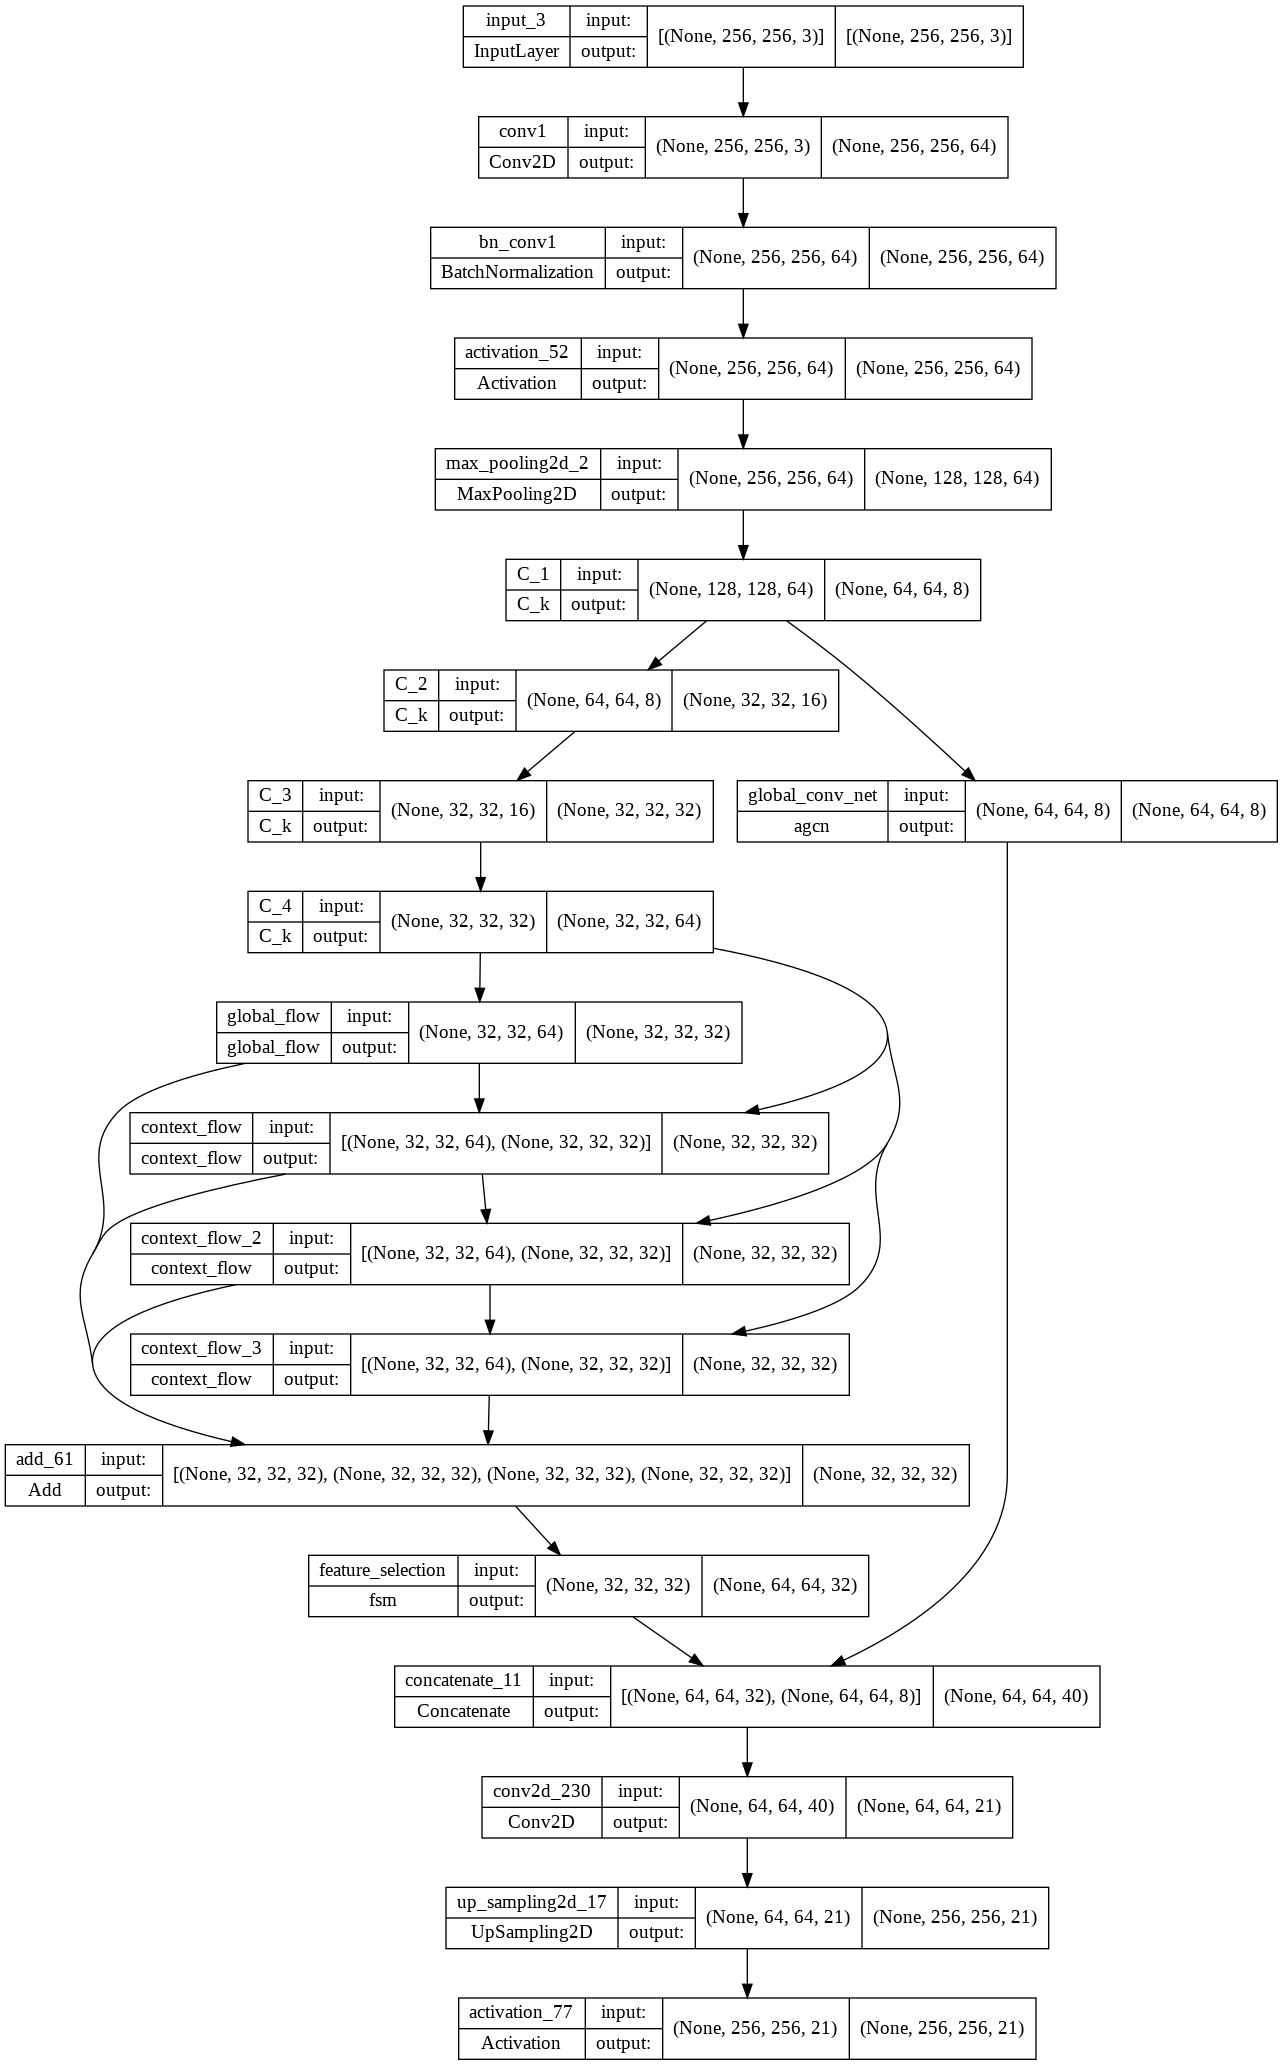

In [55]:
tf.keras.utils.plot_model(
    model, to_file='model4.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

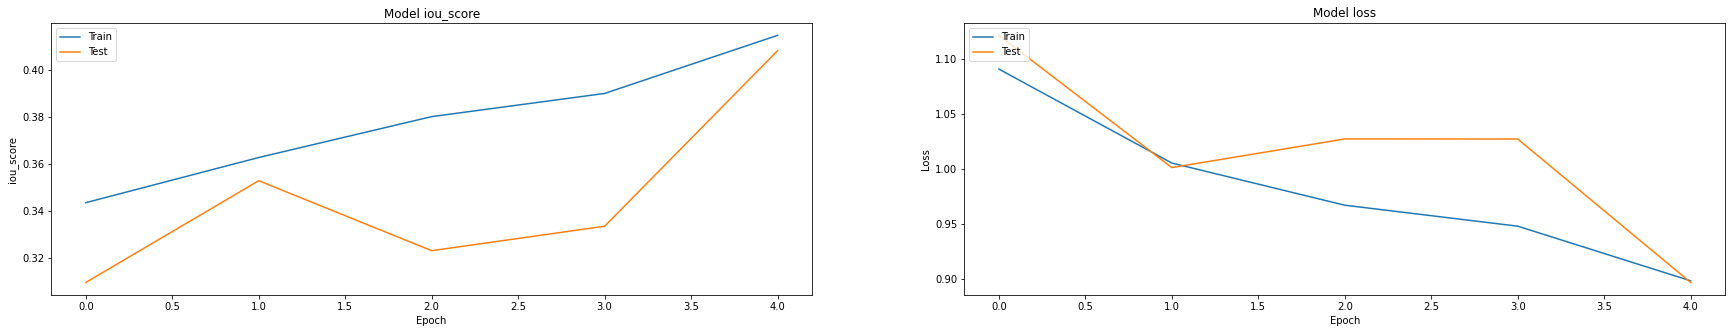

In [49]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

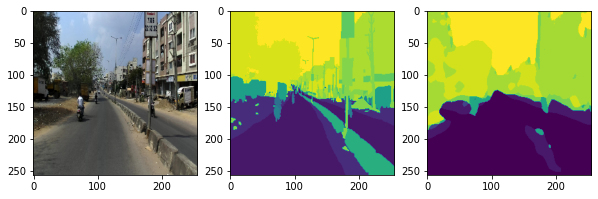

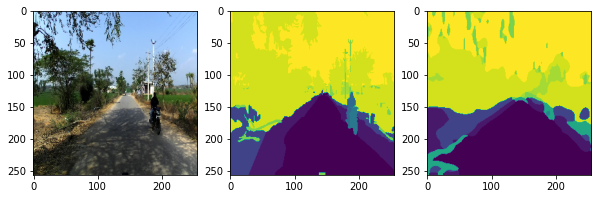

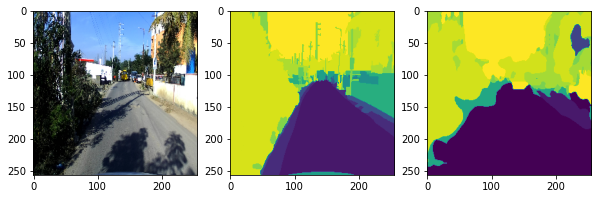

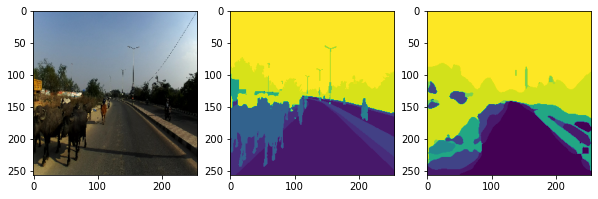

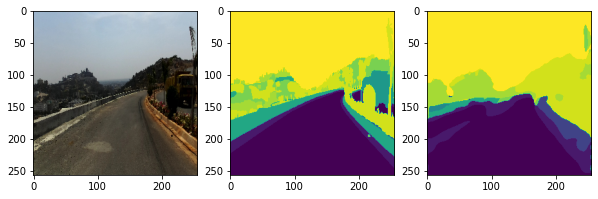

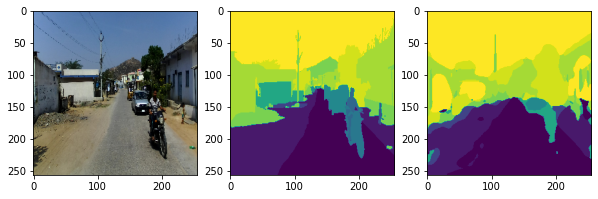

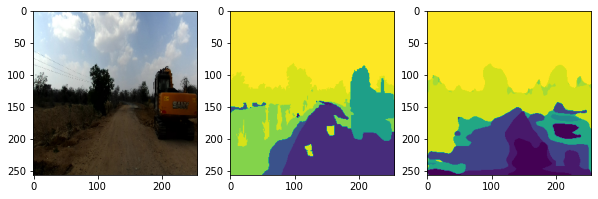

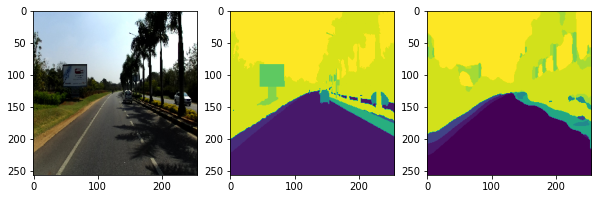

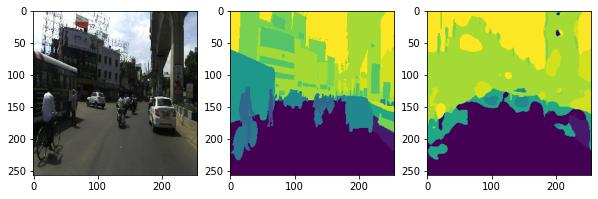

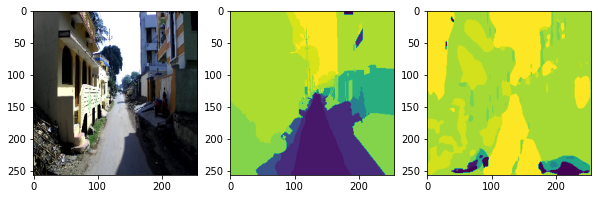

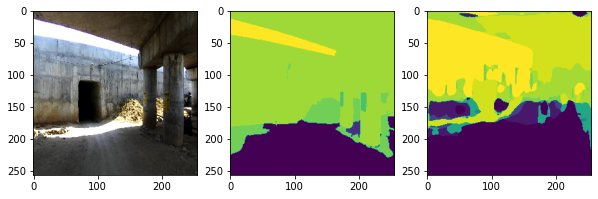

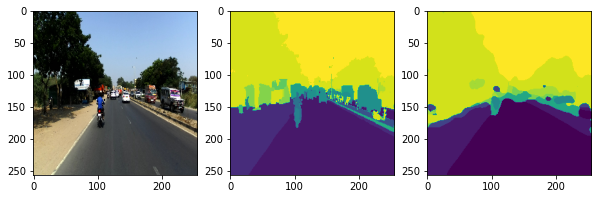

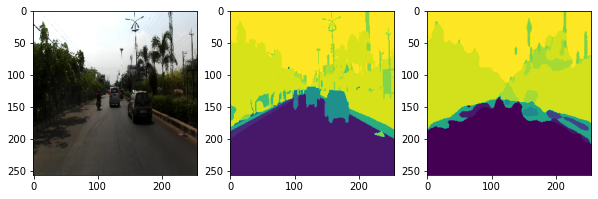

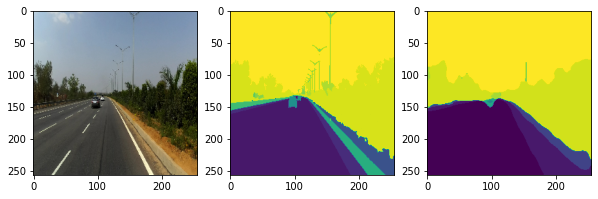

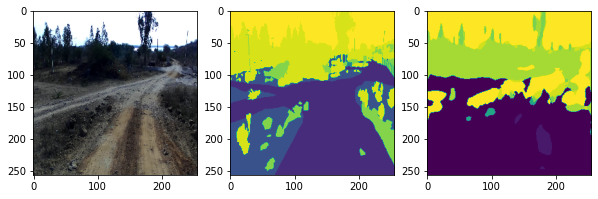

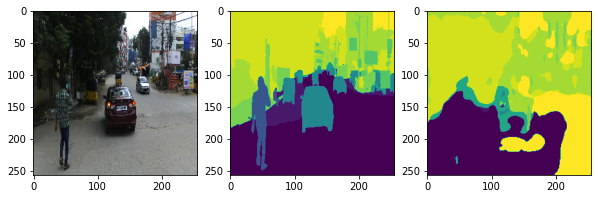

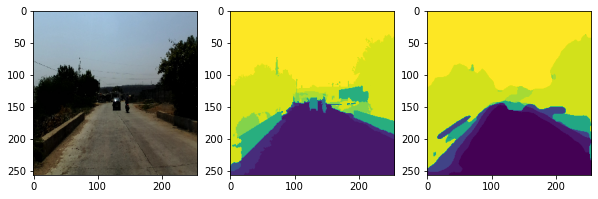

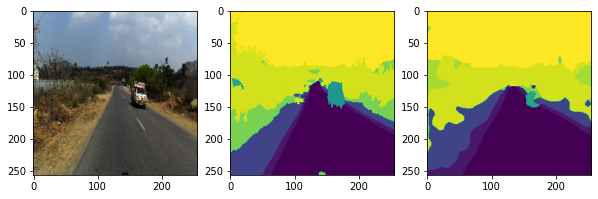

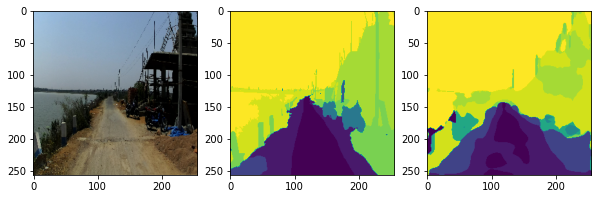

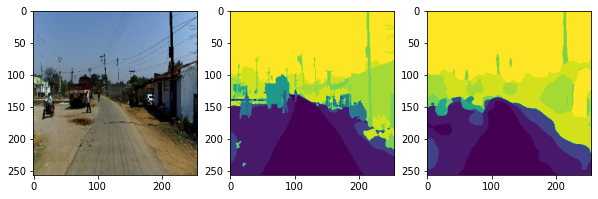

In [52]:
for p, i in enumerate(X_test['image'].values[:20]):
    #original image
    image = cv2.imread(i, cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image,(256,256),interpolation=cv2.INTER_NEAREST)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    nor_image = normalize_image(image) 
    
    #predicted segmentation map
    predicted  = model.predict(nor_image[np.newaxis,:,:,:])
    predicted = tf.argmax(predicted, axis=-1)
    
    #original segmentation map
    image_mask = cv2.imread(X_test['mask'].values[p], cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (256,256),interpolation=cv2.INTER_NEAREST)
    
    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask)
    plt.subplot(133)
    plt.imshow(predicted[0])
    plt.show()